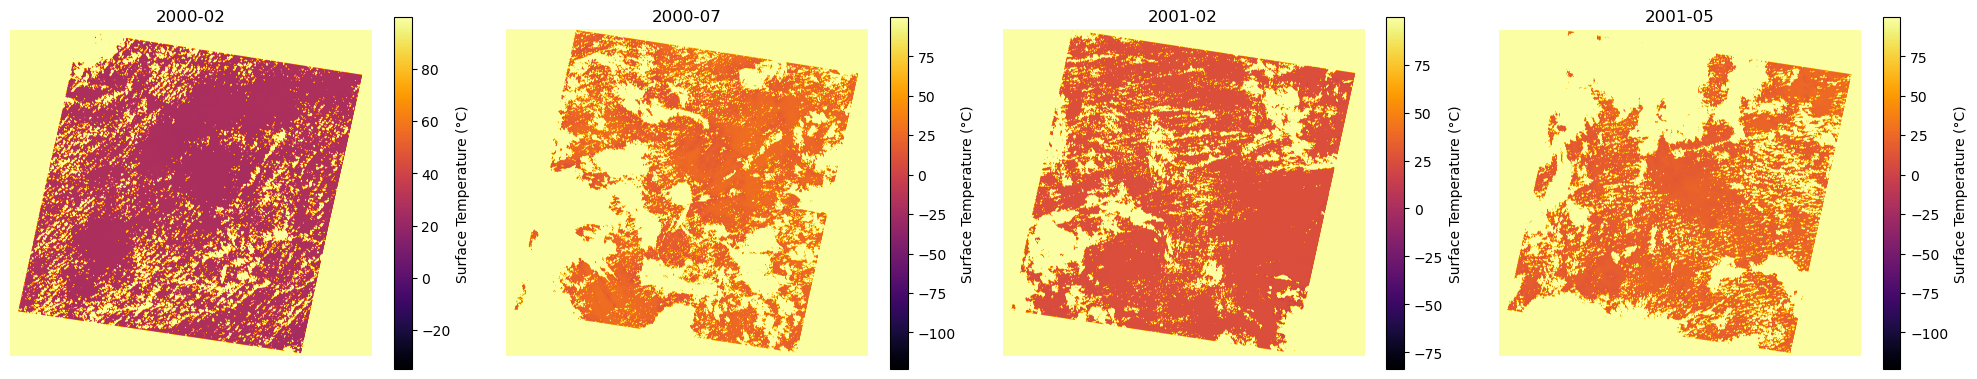

In [14]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

#load the TIFF files
mask_tiff = ["L5Mask_2000_02.TIFF",
             "L5Mask_2000_07.TIFF",
             "L5Mask_2001_02.TIFF",
             "L5Mask_2001_05.TIFF",
            ]

dates = ["2000-02", "2000-07", "2001-02", "2001-05"]

#Scale Factors:
MULT, ADD = 0.00341802, 149.0

scenes = []
indices = [0,1,2,3]


#convert temps and visualize the data
for tif in mask_tiff:
    with rasterio.open(tif) as src:
        DN = src.read(1).astype("float32")
        DN[DN==0] = np.nan # remove not a number
        tempC = (DN * MULT + ADD) - 273.15
        scenes.append(tempC)

rows = 4
cols = 4

plt.figure(figsize = (20,15))
for i, idx in enumerate(indices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(scenes[idx], cmap = "inferno")
    plt.title(dates[idx])
    plt.colorbar(label="Surface Temperature (°C)")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
stats = []

for date, img in zip(dates, scenes):
    stats.append({
        "date": date,
        "Mean": np.nanmean(img),
        "Min": np.nanmin(img),
        "Max": np.nanmax(img),
        "Standard Deviation": np.nanstd(img)
        })

df_stats = pd.DataFrame(stats)
print (df_stats)
df_stats.to_csv("sst_stats.csv", index = False)

      date       Mean         Min        Max  Standard Deviation
0  2000-02  60.918625  -34.895233  99.849945           36.421993
1  2000-07  71.702400 -123.148514  99.849945           37.991894
2  2001-02  61.931332  -83.684052  99.849945           37.457611
3  2001-05  70.663795 -123.148514  99.849945           38.993721


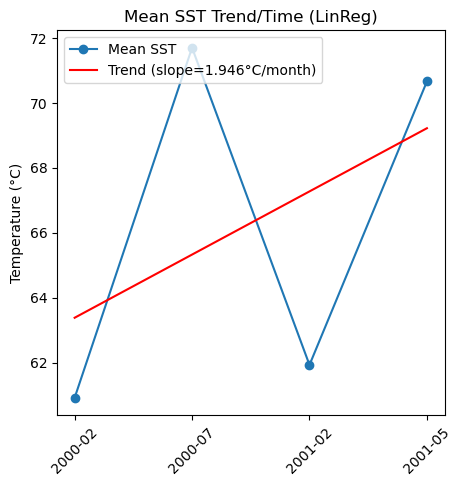

In [16]:
##Linear Regression test
from scipy.stats import linregress

x = np.arange(len(df_stats))
y = df_stats["Mean"].values

slope, intercept, r, p, stderr = linregress(x, y)

plt.figure(figsize = (5,5))
plt.plot(df_stats["date"], y, marker="o", label="Mean SST")
plt.plot(df_stats["date"], intercept + slope*x, 'r', label=f"Trend (slope={slope:.3f}°C/month)")

plt.xticks(rotation=45)
plt.ylabel("Temperature (°C)")
plt.title("Mean SST Trend/Time (LinReg)")
plt.legend()
plt.show()

Trend: no trend
H (True if trend is present): False
P-value: 0.7340951823194757
Z-statistic: 0.3396831102433787
Mann-Kendall S: 2.0
Variance of S: 8.666666666666666
Sen's slope: 1.8773717880249023
Intercept: 63.48150587081909


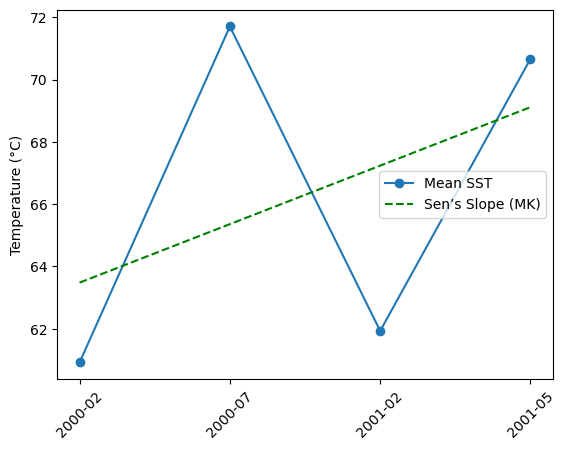

In [17]:
#Mann-Kendall Test
!pip install pymannkendall
import numpy as np
import pymannkendall as mk

data = df_stats["Mean"].values
y = df_stats["Mean"].values
years = df_stats["date"]


# Correct function name:
result = mk.original_test(data)

print(f"Trend: {result.trend}")
print(f"H (True if trend is present): {result.h}")
print(f"P-value: {result.p}")
print(f"Z-statistic: {result.z}")
print(f"Mann-Kendall S: {result.s}")
print(f"Variance of S: {result.var_s}")
print(f"Sen's slope: {result.slope}")
print(f"Intercept: {result.intercept}")

x_numeric = np.arange(len(y))

mk_result = mk.original_test(y)

sen_line = mk_result.intercept + mk_result.slope * x_numeric

plt.plot(years, y, 'o-', label="Mean SST")
plt.plot(years, sen_line, 'g--', label="Sen’s Slope (MK)")
plt.xticks(rotation=45)
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()